# PyGIMLi - Electrical Resistivity Tomography

Using the ERT solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_ert/pygimli_ert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/environment.yml) file
specifies a list of packages required to run the notebooks)

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
# !MINICONDA_PREFIX=/usr/local
# !wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# !chmod +x $MINICONDA_INSTALLER_SCRIPT
# !./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX
# !conda install -c gimli pygimli -y

# import sys
# _ = (sys.path.append("/usr/local/lib/python3.7/site-packages"))

We will need the following packages:

- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

Additionally, we wrap some `pygimli` code in file `pygimli_ert_lib.py` and import it
here for conciseness.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli
from pygimli import meshtools
from pygimli.physics import ert

from cofi import BaseProblem, InversionOptions, Inversion
from cofi.solvers import BaseSolver

from pygimli_ert_lib import *

np.random.seed(42)

## 1. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

Text(0.5, 1.0, 'True model')

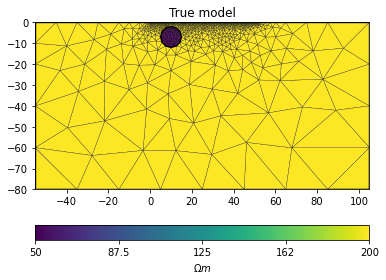

In [3]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = survey_scheme()
mesh, rhomap = model_true(scheme)

# plot the true model
ax = pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True)
ax[0].set_title("True model")

Generate the synthetic data as a container with all the necessary information for plotting.

14/07/22 - 12:25:19 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.013 s
FOP updating mesh dependencies ... 0 s
Obtaining geometric factors (analytical)
Calculating response for model: min = 50 max = 200
Allocating memory for primary potential...... 0.003

No primary potential for secondary field calculation. Calculating analytically...
Factorize (Cholmod) matrix ... 0.006
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.00

Text(0.5, 1.0, 'Provided data')

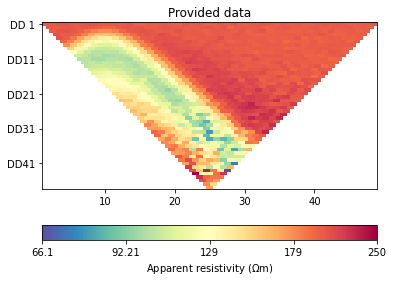

In [4]:
# PyGIMLi - generate data
data, log_data = ert_simulate(mesh, scheme, rhomap)

ax = ert.show(data)
ax[0].set_title("Provided data")

Further, we create a `pygimli.ert.ERTManager` instance to keep record of problem-specific
information like the inversion mesh, and to perform forward operation for the inversion
solvers.

In [5]:
# create PyGIMLi's ERT manager
ert_manager = ert_manager(data)

The inversion can use a different mesh and the mesh to be used should know nothing about the mesh that was designed based on the true model. We wrap two kinds of mesh as examples in the library code `pygimli_ert_lib.py`, namely triangular and rectangular mesh.

Use `imesh_tri = inversion_mesh(scheme)` to initialise a triangular mesh. This function uses PyGIMLi's own mesh generator
and generates triangular mesh automatically from given sensor locations. The resulting mesh will have a smaller area as 
unknowns to be inverted, as well as a background part with values prolongated outside from the parametric domain by PyGIMLi.
You will see an example plot in the code cell below. 

Use `imesh_rect = inversion_mesh_rect(ert_manager)` to initislise a rectangular mesh. The grid mesh is created from these x and y
nodes: `x = np.linspace(start=-5, stop=55, num=61)`, and `y = np.linspace(start=-20,stop=0,num=10)`. And again, there's a triangular
background with values prolongated outside from the parametric domain by PyGIMLi.

Here we first demonstrate how to use a *triangular mesh*. Note that this makes the inversion problem under-determined.

14/07/22 - 12:25:20 - pyGIMLi - INFO - Found 2 regions.


14/07/22 - 12:25:20 - pyGIMLi - INFO - Region with smallest marker (1) set to background


Text(0.5, 1.0, 'Mesh used for inversion')

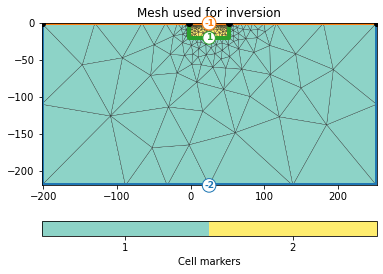

In [6]:
inv_mesh = inversion_mesh(ert_manager)
ax = pygimli.show(inv_mesh, showMesh=True, markers=True)
ax[0].set_title("Mesh used for inversion")

Check [here](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_ert)
for inversion examples using triangular mesh.

With the inversion mesh created, we now define a starting model, forward operator and 
weighting matrix for regularisation using PyGIMLi.

14/07/22 - 12:25:20 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.


14/07/22 - 12:25:20 - Core - WARNING - Region Nr: 1  is background and should not get a model control.


14/07/22 - 12:25:20 - pyGIMLi - INFO - Creating forward mesh from region infos.


14/07/22 - 12:25:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Text(0.5, 1.0, 'Starting model')

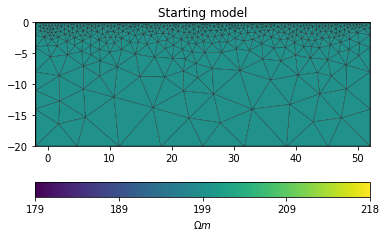

In [7]:
# PyGIMLi's forward operator (ERTModelling)
forward_oprt = ert_forward_operator(ert_manager, scheme, inv_mesh)

# extract regularisation matrix
Wm = reg_matrix(forward_oprt)

# initialise a starting model for inversion
start_model = starting_model(ert_manager)
ax = pygimli.show(ert_manager.paraDomain, data=start_model, label="$\Omega m$", showMesh=True)
ax[0].set_title("Starting model")

CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined in the library file `pygimli_ert_lib.py`, so open this file if you'd like to find out the details. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_misfit`
- `get_regularisation`
- `get_gradient`
- `get_hessian`

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [8]:
# hyperparameters
lamda = 0.0005

# CoFI - define BaseProblem
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_oprt])
ert_problem.set_jacobian(get_jacobian, args=[forward_oprt])
ert_problem.set_residual(get_residual, args=[log_data, forward_oprt])
ert_problem.set_data_misfit(get_data_misfit, args=[log_data, forward_oprt])
ert_problem.set_regularisation(get_regularisation, args=[Wm, lamda])
ert_problem.set_gradient(get_gradient, args=[log_data, forward_oprt, Wm, lamda])
ert_problem.set_hessian(get_hessian, args=[log_data, forward_oprt, Wm, lamda])
ert_problem.set_initial_model(start_model)

Review what information is included in the `BaseProblem` object:

In [9]:
ert_problem.summary()

Summary for inversion problem: Electrical Resistivity Tomography defined through PyGIMLi
Model shape: (831,)
----------------------------------------------------------------------------------------
List of functions/properties set by you:
['gradient', 'hessian', 'residual', 'jacobian', 'data_misfit', 'regularisation', 'forward', 'initial_model', 'model_shape']
----------------------------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'hessian_times_vector', 'jacobian_times_vector']
----------------------------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'jacobian_times_vector', 'data', 'data_covariance', 'data_covariance_inv', 'walkers_starting_pos', 'blobs_dtype', 'bounds', 'constraints']


## 2. Define the inversion options and run

### 2.1 SciPy's optimiser ([TNC](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-tnc.html#optimize-minimize-tnc))

In [10]:
ert_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimisation": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "linear least square": [],
    "sampling": []
}


In [11]:
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="trust-constr")

Review what's been defined for the inversion we are about to run:

In [12]:
inv_options_scipy.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.optimize.minimize` - SciPy's optimisers that minimises a scalar function with respect to one or more variables, check SciPy's documentation page for a list of methods
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
method = trust-constr
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [13]:
inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
nit: 533
nfev: 533
njev: 506
nhev: 506
cg_niter: 532
cg_stop_cond: 2
fun: 61.261303734246994
grad: [-3.11162557e-02 -2.40993447e-03  2.65305045e-01 -1.61723295e-01
  5.03653024e-02  2.80906137e-01 -3.55337500e-02  2.03139605e-03
  8.72587657e-02 -5.75013394e-02  1.03381743e-02 -1.83579909e-01
  1.66401747e-02  5.24298506e-02  6.87353893e-03  8.33876711e-03
  4.43329761e-02 -1.65491747e-01 -9.86688247e-03 -8.42407296e-03
  1.76107060e-02  6.55326099e-01  1.61361988e-02  6.44113955e-02
  5.49789426e-02 -6.46034100e-03  7.36761602e-02  1.51415239e-01
  5.08218678e-03  2.08687788e-01  9.22644408e-02 -3.05640192e-02
  1.39179859e-01 -5.23179730e-02  1.08404066e-01  1.79431728e-01
  3.30765221e-01  1.16249404e-02  1.06409340e-02 -2.62566243e-01
  5.90122174e-02 -3.12778043e-01  3.69394649e-01  2.12662668e-02
  3.70361088e-01 -5.76166258e-03  4.52488493e-02  7.42871566e-02
 -1.63796558e-01 -1.65222277e-01 -7.85086190e-02 -1.662

In [14]:
inv_result.success

True

Plot the results:

Summary for inversion result
SUCCESS
----------------------------
nit: 533
nfev: 533
njev: 506
nhev: 506
cg_niter: 532
cg_stop_cond: 2
fun: 61.261303734246994
grad: [-3.11162557e-02 -2.40993447e-03  2.65305045e-01 -1.61723295e-01
  5.03653024e-02  2.80906137e-01 -3.55337500e-02  2.03139605e-03
  8.72587657e-02 -5.75013394e-02  1.03381743e-02 -1.83579909e-01
  1.66401747e-02  5.24298506e-02  6.87353893e-03  8.33876711e-03
  4.43329761e-02 -1.65491747e-01 -9.86688247e-03 -8.42407296e-03
  1.76107060e-02  6.55326099e-01  1.61361988e-02  6.44113955e-02
  5.49789426e-02 -6.46034100e-03  7.36761602e-02  1.51415239e-01
  5.08218678e-03  2.08687788e-01  9.22644408e-02 -3.05640192e-02
  1.39179859e-01 -5.23179730e-02  1.08404066e-01  1.79431728e-01
  3.30765221e-01  1.16249404e-02  1.06409340e-02 -2.62566243e-01
  5.90122174e-02 -3.12778043e-01  3.69394649e-01  2.12662668e-02
  3.70361088e-01 -5.76166258e-03  4.52488493e-02  7.42871566e-02
 -1.63796558e-01 -1.65222277e-01 -7.85086190e-02 -1.662

Text(0.5, 1.0, 'Inferred model')

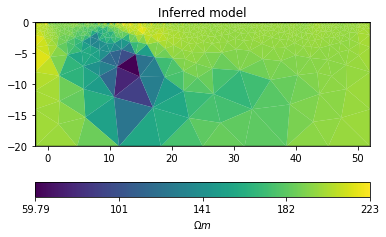

In [15]:
# plot inferred model
inv_result.summary()
ax = pygimli.show(ert_manager.paraDomain, data=inv_result.model, label=r"$\Omega m$")
ax[0].set_title("Inferred model")

Text(0.5, 1.0, 'Synthetic data from inferred model')

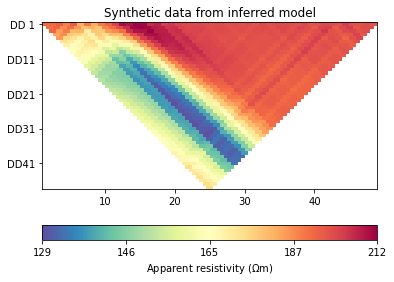

In [16]:
# plot synthetic data
d = forward_oprt.response(inv_result.model)
ax = ert.showERTData(scheme, vals=d)
ax[0].set_title("Synthetic data from inferred model")

### 2.2 A custom [Newton's optimisation](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) approach

Now we switch to a Newton's iterative approach written by ourselves, so you'll 
have a closer look at what's happening in the loop.

First of all, define our own solver.

In [17]:
class GaussNewton(BaseSolver):
    def __init__(self, inv_problem, inv_options):
        __params = inv_options.get_params()
        self._niter = __params.get("niter", 100)
        self._verbose = __params.get("verbose", True)
        self._step = __params.get("step", 1)
        self._model_0 = inv_problem.initial_model
        self._residual = inv_problem.residual
        self._jacobian = inv_problem.jacobian
        self._gradient = inv_problem.gradient
        self._hessian = inv_problem.hessian
        self._misfit = inv_problem.data_misfit if inv_problem.data_misfit_defined else None
        self._reg = inv_problem.regularisation if inv_problem.regularisation_defined else None
        self._obj = inv_problem.objective if inv_problem.objective_defined else None

    def __call__(self):
        current_model = np.array(self._model_0)
        for i in range(self._niter):
            if self._verbose:
                print("-" * 80)
                print(f"Iteration {i+1}")
                print("model min and max:", np.min(current_model), np.max(current_model))
                if self._misfit: print("data misfit:", self._misfit(current_model))
                if self._reg: print("regularisation:", self._reg(current_model))
            term1 = self._hessian(current_model)
            term2 = - self._gradient(current_model)
            model_update = np.linalg.solve(term1, term2) * self._step
            current_model = np.array(current_model + model_update)
        return {"model": current_model, "success": True}

Now, make use of this custom solver and run inversion again:

In [18]:
# hyperparameters
niter = 50
inv_verbose = True
step = 2

# CoFI - define InversionOptions
inv_options_gauss_newton = InversionOptions()
inv_options_gauss_newton.set_tool(GaussNewton)
inv_options_gauss_newton.set_params(niter=niter, verbose=inv_verbose, step=step)

# CoFI - define Inversion, run it
inv = Inversion(ert_problem, inv_options_gauss_newton)
inv_result = inv.run()

--------------------------------------------------------------------------------
Iteration 1
model min and max: 198.60359307964035 198.60359307964035
data misfit: 114.25204386526127
regularisation: 9.321937762560492e-28


--------------------------------------------------------------------------------
Iteration 2
model min and max: 193.3724998096491 204.26638012558683
data misfit: 111.83308633048894
regularisation: 0.09372234111296376


--------------------------------------------------------------------------------
Iteration 3
model min and max: 188.8466686899677 206.6549104831427
data misfit: 109.44315552012856
regularisation: 0.14907249357850566


--------------------------------------------------------------------------------
Iteration 4
model min and max: 184.06207931252177 208.66524526574324


data misfit: 107.20039508808304
regularisation: 0.26375446402015124


--------------------------------------------------------------------------------
Iteration 5
model min and max: 179.47601135540282 210.5893178906895


data misfit: 104.9123735117388
regularisation: 0.3631749444952161


--------------------------------------------------------------------------------
Iteration 6
model min and max: 175.00037430496596 211.7209415601775


data misfit: 102.72261051827316
regularisation: 0.4993205241984091


--------------------------------------------------------------------------------
Iteration 7
model min and max: 170.6215899438995 213.4760566645871


data misfit: 100.49244642292804
regularisation: 0.6278430436546707


--------------------------------------------------------------------------------
Iteration 8
model min and max: 166.39331794027632 214.2840336255118


data misfit: 98.3414358397283
regularisation: 0.7826837617542064


--------------------------------------------------------------------------------
Iteration 9
model min and max: 162.22251700231865 215.8389524029794


data misfit: 96.15530152520198
regularisation: 0.9327443768748582


--------------------------------------------------------------------------------
Iteration 10
model min and max: 158.20886234284367 216.44899859216451


data misfit: 94.03915129187565
regularisation: 1.1025710299630151


--------------------------------------------------------------------------------
Iteration 11
model min and max: 154.23908312867695 217.91501439173857


data misfit: 91.8921567853571
regularisation: 1.2688170086035533


--------------------------------------------------------------------------------
Iteration 12
model min and max: 150.41926123774016 218.39554409986567
data misfit: 89.81053897849733
regularisation: 1.4503289214120458


--------------------------------------------------------------------------------
Iteration 13
model min and max: 146.64133448209253 219.83689685242135
data misfit: 87.70183994846134
regularisation: 1.6287486964227293


--------------------------------------------------------------------------------
Iteration 14
model min and max: 143.00076191385253 220.22616619526303
data misfit: 85.6561610622722
regularisation: 1.8191746252850942


--------------------------------------------------------------------------------
Iteration 15
model min and max: 139.40537728932173 221.68230594922477


data misfit: 83.58688283347672
regularisation: 2.0066532515043973


--------------------------------------------------------------------------------
Iteration 16
model min and max: 135.9331053392947 222.0008788010607
data misfit: 81.57943194113318
regularisation: 2.2036767205745775


--------------------------------------------------------------------------------
Iteration 17
model min and max: 132.51155810615305 223.497342916776


data misfit: 79.55167162884456
regularisation: 2.3977205155339396


--------------------------------------------------------------------------------
Iteration 18
model min and max: 129.19891496816254 223.7550289381349
data misfit: 77.58515949827512
regularisation: 2.5993879652329555


--------------------------------------------------------------------------------
Iteration 19
model min and max: 125.94330413534831 225.3093254668373
data misfit: 75.60147659677034
regularisation: 2.797950555838912


--------------------------------------------------------------------------------
Iteration 20
model min and max: 122.78310384606505 225.5092096850794
data misfit: 73.67876567630391
regularisation: 3.0025972299590165


--------------------------------------------------------------------------------
Iteration 21
model min and max: 119.68631208485775 227.134162342283
data misfit: 71.74190666464193
regularisation: 3.2039680263809225


--------------------------------------------------------------------------------
Iteration 22
model min and max: 116.6723647351249 227.27501956063134
data misfit: 69.86585304270668
regularisation: 3.410163554513348


--------------------------------------------------------------------------------
Iteration 23
model min and max: 113.72796260366648 228.9807129740685
data misfit: 67.97859425490981
regularisation: 3.612893900741627


--------------------------------------------------------------------------------
Iteration 24
model min and max: 110.85476427352377 229.05848144820803
data misfit: 66.15195032374093
regularisation: 3.819402410073127


--------------------------------------------------------------------------------
Iteration 25
model min and max: 108.05690098537497 230.85344847690283
data misfit: 64.31700237373704
regularisation: 4.0222547510939055


--------------------------------------------------------------------------------
Iteration 26
model min and max: 105.31942869549245 230.8621323561984
data misfit: 62.542354998231865
regularisation: 4.228004906922668


--------------------------------------------------------------------------------
Iteration 27
model min and max: 102.66272601111199 232.75405936624492


data misfit: 60.76230227546176
regularisation: 4.429916380632249


--------------------------------------------------------------------------------
Iteration 28
model min and max: 100.05630225563478 232.68630845191916


data misfit: 59.042033370894444
regularisation: 4.633978543064453


--------------------------------------------------------------------------------
Iteration 29
model min and max: 97.53576512510865 234.68248341255506
data misfit: 57.319289532107696
regularisation: 4.8340340255297525


--------------------------------------------------------------------------------
Iteration 30
model min and max: 95.05596634469845 234.52995474344434
data misfit: 55.6555449247172
regularisation: 5.035602024921024


--------------------------------------------------------------------------------
Iteration 31
model min and max: 92.66690723730402 236.63753506200808
data misfit: 53.99232652254437
regularisation: 5.233013332083052


--------------------------------------------------------------------------------
Iteration 32
model min and max: 90.30949618618588 236.3911226069633
data misfit: 52.38699707632415
regularisation: 5.431389991140898


--------------------------------------------------------------------------------
Iteration 33
model min and max: 88.0474745634783 238.61732604371275
data misfit: 50.78529307346227
regularisation: 5.625479628886959


--------------------------------------------------------------------------------
Iteration 34
model min and max: 85.80835572602689 238.26730058045985


data misfit: 49.23999841495352
regularisation: 5.8200646145071895


--------------------------------------------------------------------------------
Iteration 35
model min and max: 83.66912553554572 240.61951745227915
data misfit: 47.70155370218237
regularisation: 6.010252761065629


--------------------------------------------------------------------------------
Iteration 36
model min and max: 81.54430928150902 240.15561661540892


data misfit: 46.21763044851211
regularisation: 6.200532628924066


--------------------------------------------------------------------------------
Iteration 37
model min and max: 79.5237793072576 242.64149416825597


data misfit: 44.74392546110231
regularisation: 6.386326234386911


--------------------------------------------------------------------------------
Iteration 38
model min and max: 77.50935796095577 242.05296865093268


data misfit: 43.322415412843036
regularisation: 6.571866007609442


--------------------------------------------------------------------------------
Iteration 39
model min and max: 75.60355803699746 244.68047460344508
data misfit: 41.91465487565553
regularisation: 6.752849915532312


--------------------------------------------------------------------------------
Iteration 40
model min and max: 73.6956827835632 243.95610152532473


data misfit: 40.55630029069163
regularisation: 6.9332856780504315


--------------------------------------------------------------------------------
Iteration 41
model min and max: 71.90073790771798 246.733593858826


data misfit: 39.21539637153486
regularisation: 7.109114981604068


--------------------------------------------------------------------------------
Iteration 42
model min and max: 70.09560574249407 245.86167335817257
data misfit: 37.92063354966726
regularisation: 7.28414758638011


--------------------------------------------------------------------------------
Iteration 43
model min and max: 68.40771435247775 248.79794112900626
data misfit: 36.647198140119364
regularisation: 7.454541066761025


--------------------------------------------------------------------------------
Iteration 44
model min and max: 66.70155352035056 247.76628445374035
data misfit: 35.41615661720793
regularisation: 7.623930522611098


--------------------------------------------------------------------------------
Iteration 45
model min and max: 65.11697163294868 250.8706205463993


data misfit: 34.21049222312582
regularisation: 7.7886649810124124


--------------------------------------------------------------------------------
Iteration 46
model min and max: 63.5060335614209 249.6665151940516
data misfit: 33.04299310792935
regularisation: 7.9522254763297795


--------------------------------------------------------------------------------
Iteration 47
model min and max: 62.021061080889424 252.94877462650493


data misfit: 31.905089364237014
regularisation: 8.111130566397732


--------------------------------------------------------------------------------
Iteration 48
model min and max: 60.50161263798664 251.55893325987057
data misfit: 30.80065058169623
regularisation: 8.268725890929284


--------------------------------------------------------------------------------
Iteration 49
model min and max: 59.11258634204331 255.02960805053286
data misfit: 29.73018355887234
regularisation: 8.421679595937084


--------------------------------------------------------------------------------
Iteration 50
model min and max: 57.68090347438274 253.4401243909579


data misfit: 28.68802472169119
regularisation: 8.573219002251633


Summary for inversion result
SUCCESS
----------------------------
model: [198.53357836 199.81009459 200.7862735  202.80280196 197.68145749
 202.55912501 206.09441795 199.90015234 199.65776634 214.54118261
 201.77607292 201.35319417 200.02202479 204.16423251 198.45128533
 201.53884287 200.62069207 198.85989573 202.12167269 200.09352635
 200.70882484 198.19649973 201.96234297 201.11455992 203.09292037
 199.0250386  199.10590976 197.78923882 198.53202737 197.2762488
 200.13270341 203.92796993 200.4110229  203.13011761 198.34925869
 195.99387088 199.17598243 200.08558324 200.31291695 198.67206107
 201.72957767 199.71745368 198.87262824 199.4289063  195.09465594
 199.39989182 200.1041334  200.95596937 198.50420367 197.13954493
 198.66139146 199.91786902 197.85430623 200.12145805 202.11623842
 198.58050288 197.960785   178.98505003 198.07940491 193.49151724
 203.96793346 197.65633602 198.88215861 199.93297782 200.3045929
 201.60112176 196.11421662 195.13294115 198.8317631  191.317315
 195.87

Text(0.5, 1.0, 'Inferred model')

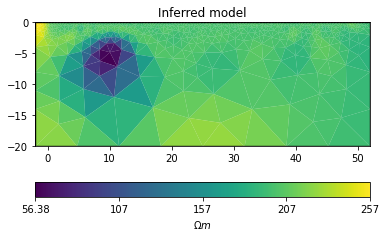

In [19]:
# plot inferred model
inv_result.summary()
ax = pygimli.show(ert_manager.paraDomain, data=inv_result.model, label=r"$\Omega m$")
ax[0].set_title("Inferred model")

Text(0.5, 1.0, 'Synthetic data from inferred model')

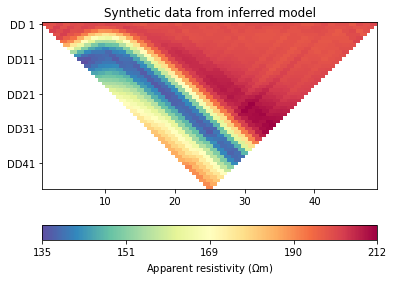

In [20]:
# plot synthetic data
d = forward_oprt.response(inv_result.model)
ax = ert.showERTData(scheme, vals=d)
ax[0].set_title("Synthetic data from inferred model")

<!-- ### 2.3 Bayesian sampling with emcee (exploration)

CoFI needs more assumptions about the problem for a sampler to work - these are
the log of posterior distribution density and walkers' starting positions.

For the log posterior, we define here by specifying `log_prior` and `log_likelihood`.
And CoFI will combine them to get the `log_posterior`. -->

---
## Watermark

In [21]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev8
numpy 1.21.6
scipy 1.8.1
pygimli 1.2.6
matplotlib 3.5.2
emcee 3.1.2
arviz 0.12.1
